### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [2]:
from openai import OpenAI
import sys
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import calendar
import holidays
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import random
import pandas as pd
from tqdm import tqdm
import pypfopt
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

tickers = ["NVDA", "GOOG", "MSTR", "SMCI"]

#### Functions to save data locally

In [3]:
def save_data(data, file_path='assets/stock_data.json'):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path='assets/stock_data.json'):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path='assets/stock_data.json'
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary with MSTR & SMCI if they don't exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                print(f'patched: month {months[i]}\t{ticker}')
            else:
                print(f'skipping: {ticker}')
            
            save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [4]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]


def get_news():

    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }
        
    for i in range(len(months)):
        data.append({})
        for ticker in tickers:
            messages = [
                system_prompt,
                {   
                    "role": "user",
                    "content": (
                        f"What happened to {ticker} in {months[i]} 2024?"
                    ),
                },
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            )
            
            data[i][ticker] = {}
            data[i][ticker]["news"] = response.choices[0].message.content

# get_news()
# save_data(data)

#### Loading the S&P 500 tickers

In [5]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

constituents

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 

#### Patching data for tickers

In [6]:
# patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 964.32it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1098.85it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1005.29it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1033.33it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 612.08it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 843.92it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1134.36it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1265.54it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1115.06it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1261.82it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1184.41it/s]


skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json


100%|██████████| 4/4 [00:00<00:00, 1333.85it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Get ticker prices

In [7]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        prices = get_stock_price(tickers, datetime_obj)

        for i, ticker in enumerate(tickers):
            data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

# get_closing_prices(data_loaded)
data_loaded = load_data()

Data loaded from assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [8]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

tickers = ["NVDA", "GOOG", "MSTR", "SMCI"] 

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv("assets/portfolio.csv", index=True)
portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")

[*********************100%***********************]  4 of 4 completed


#### Historical ticker prices

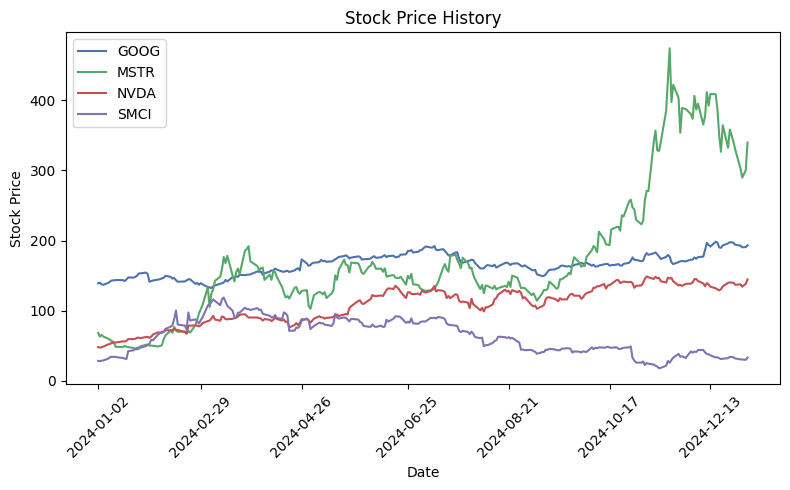

In [9]:
df = portfolio

# Plot
plt.figure(figsize=(8, 5))

# Plot each column
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d')
           for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig('figures/stock_price_history.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

Expected annual return: 192.0%
Annual volatility: 58.5%
Sharpe Ratio: 3.25


GOOG    0.320786
MSTR    2.587188
NVDA    1.093368
SMCI    3.042328
Name: mkt, dtype: float64

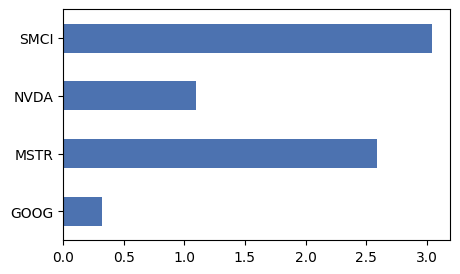

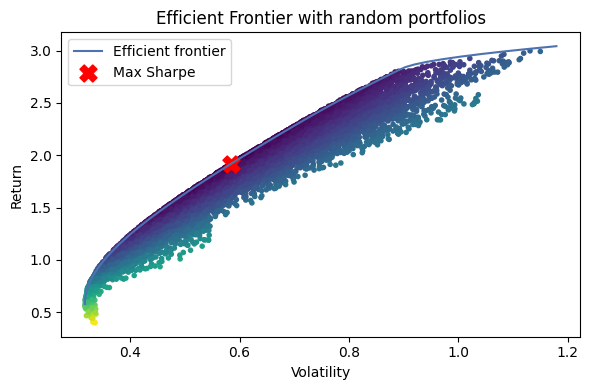

In [10]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [11]:
# brief stock introductions obtained from Perplexity.ai
NVDA_report = "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years."
GOOG_report = "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue source is Google's advertising business, which includes Google Search and YouTube. However, Alphabet has diversified its operations to include cloud computing (Google Cloud), hardware products, and investments in emerging technologies through various subsidiaries. In Q3 2024, Alphabet reported strong financial performance with a 15% revenue increase, driven by Google Services and a 35% surge in Google Cloud revenue. The company is heavily investing in AI initiatives, integrating AI across its products and services to drive user engagement and improve efficiency."
MSTR_report = "MicroStrategy is an American company that provides business intelligence, mobile software, and cloud-based services. Founded in 1989 and headquartered in Tysons Corner, Virginia, MicroStrategy has evolved beyond its traditional software offerings. The company gained significant attention in recent years for its substantial investments in Bitcoin, effectively becoming a proxy for Bitcoin in the stock market. MicroStrategy's product lineup includes MicroStrategy ONE, an AI-powered enterprise analytics software, and various cloud services. The company serves a diverse range of industries, including retail, banking, healthcare, and the public sector. Under the leadership of CEO Phong Le, MicroStrategy continues to balance its software business with its significant cryptocurrency holdings."
SMCI_report = "Super Micro Computer, Inc., commonly known as Supermicro, is an American information technology company based in San Jose, California. Founded in 1993, Supermicro has become one of the largest producers of high-performance and high-efficiency servers, storage systems, and server management software. The company focuses on providing solutions for various markets, including enterprise data centers, cloud computing, artificial intelligence, 5G, and edge computing. Supermicro has gained attention in recent years for its growth in the AI infrastructure market, particularly with the increasing demand for AI-optimized systems. The company's commitment to green computing and its \"Resource-Saving Architecture\" has also been recognized in the industry. Supermicro's recent financial performance has been strong, with the company joining the S&P 500 and Nasdaq-100 indices in 2024"


def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

# create a dictionary containing the stock name and the corresponding report
stock_reports = {"NVDA": NVDA_report, "GOOG": GOOG_report, "MSTR": MSTR_report, "SMCI": SMCI_report}

initial_stock_info = generate_data_summary(stock_reports)

#### Main class to integrate the LLM with the Portfolio Optimization model

In [12]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, verbose=False):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        stock_prices = f"The stock prices today are:\n"
        for i, ticker in enumerate(tickers):
            ticker_close = month_data[ticker]['price']
            stock_prices += f"{ticker} = {ticker_close}"
            if i != len(tickers) - 1:
                stock_prices += ", "
        stock_prices += "\n"

        stock_news = ""
        for ticker in tickers:
            ticker_news = month_data[ticker]['news']
            stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

        if iter == 0:
            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            "2. Any patterns in recent price movements.\n"
            "3. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.optimization_plan != [0.0] * self.n:
            current_prompt += (
                "Also, here is the **current optimizer plan**:\n"
                f"{self.optimization_plan}\n\n"
                "Decide whether you agree with the optimizer's plan. If you do, make any necessary adjustments to "
                "move your portfolio allocation closer to it.\n\n"
            )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. **Explain your decision process**. Discuss your reasoning and any trade-offs you considered.\n"
            "2. **Provide a recommended investment decision** for each stock in terms of confidence, choosing from "
            "one of the following 7 levels:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "### Response Format\n"
            "After your explanation, write your final recommendation in a single line, in the format below:\n\n"
        )

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        current_prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        current_prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        current_prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        current_prompt += (
            " with the confidence level for each stock."
        )
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter} prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting."
                else: # if retry_reason == "ZERO SUM" 
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again"

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })
            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"[DEBUG]\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High Confidence": 0.6,
                "High Confidence": 0.5,
                "Somewhat High Confidence": 0.4,
                "Neutral": 0.3,
                "Somewhat Low Confidence": 0.2,
                "Low Confidence": 0.1,
                "Very Low Confidence": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            for stock in tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                else:
                    retry = True
                    if verbose:
                        print("[DEBUG]\tInvalid format, retrying.")
                        print(f"[DEBUG]\tfetched weights: {result_dict}")
                    continue

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print("[DEBUG]\tInvalid output: sum = 0")
                return True

            if verbose:
                print(f"[DEBUG]\tfetched weights: {result_dict = }")
                retry = False
            

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        try:
            for i in range(len(all_llm_opt_plans[0])-1): # that's the number of columns we have
                if not abs(all_llm_opt_plans[-1][i+1] - all_llm_opt_plans[-2][i+1]) <= 1/20:
                    return False
            return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
            return False
        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            prices = yf.download(tickers, start=start_date, end=end_date)
            portfolio = prices["Adj Close"].dropna(how="all")
            portfolio.to_csv("assets/portfolio.csv", index=True)
            portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")
            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            prices = yf.download(tickers, start=start_date, end=end_date)
            portfolio = prices["Adj Close"].dropna(how="all")
            portfolio.to_csv("assets/portfolio.csv", index=True)
            portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")
            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df)
                    break

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df)
                    print("\n```\n")

        return self.plan_histories

In [13]:
CoordFW = CoordinationFramework(
    mu, S, 1.42, penalty=1, iteration=20, verbose=False)

#### Run the optimizer only, as baseline

In [18]:
# opt_histories = CoordFW.OptAlgorithm(data_loaded)
# with open("assets/weights_opt.json", "w") as f:
#     json.dump(opt_histories, f, indent=4)

# -- OR --

with open("assets/weights_opt.json", "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.27477487051202115,
  0.23662697612577244,
  0.2589507222612862,
  0.22964743110092006],
 [0.27312528449488305,
  0.24486212762231746,
  0.2608853467445003,
  0.22112724113829965],
 [0.37399508495168227,
  0.2368691554191473,
  0.28234126696825007,
  0.10679449266092064],
 [0.4704074903039556,
  0.10832867963699629,
  0.3221817051369531,
  0.09908212492210142],
 [0.9969692370492997,
  4.0738954721372187e-10,
  0.0030307619682247637,
  5.751446448166134e-10],
 [0.929419324922078,
  8.069040357007231e-10,
  0.04850403756533965,
  0.022076636705731265],
 [0.8225503911583352,
  0.028089790485197726,
  0.08313120991212476,
  0.0662286084443385],
 [0.6959977090763003,
  0.28165509704672403,
  0.022039652330467844,
  0.00030754154307253035],
 [0.0582860064515391,
  1.4058870206937622e-10,
  0.9417139933742446,
  3.362821029219489e-11],
 [0.11633124784822745,
  0.044503520050730876,
  0.8065149157952025,
  0.032650316305814504],
 [0.1782819763107368,
  0.11195738411795664,
  0.6165834928373

#### Run the LLM only, as baseline

In [17]:
# llm_histories = CoordFW.LLMAlgorithm(data_loaded, False)
# with open("assets/weights_llm.json", "w") as f:
#     json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open("assets/weights_llm.json", "r") as f:
    llm_histories = json.load(f)

llm_histories

[[0.46153846153846156, 0.30769230769230776, 0.0, 0.23076923076923078],
 [0.4000000000000001,
  0.2666666666666667,
  0.13333333333333336,
  0.20000000000000004],
 [0.375, 0.3125, 0.125, 0.1875],
 [0.5, 0.41666666666666674, 0.08333333333333334, 0.0],
 [0.46153846153846156, 0.3846153846153847, 0.15384615384615388, 0.0],
 [0.5, 0.41666666666666674, 0.08333333333333334, 0.0],
 [0.28571428571428575,
  0.28571428571428575,
  0.35714285714285715,
  0.07142857142857144],
 [0.4166666666666667, 0.33333333333333337, 0.25, 0.0],
 [0.36363636363636365, 0.36363636363636365, 0.2727272727272727, 0.0],
 [0.3076923076923077, 0.3846153846153846, 0.3076923076923077, 0.0],
 [0.33333333333333337, 0.4166666666666667, 0.25, 0.0],
 [0.4, 0.5, 0.1, 0.0],
 [0.33333333333333337, 0.4166666666666667, 0.25, 0.0],
 [0.33333333333333337, 0.4166666666666667, 0.25, 0.0],
 [0.4166666666666667, 0.33333333333333337, 0.25, 0.0],
 [0.4285714285714286, 0.35714285714285715, 0.2142857142857143, 0.0],
 [0.4285714285714286, 0.357

#### Run the coordinator algorithm

In [ ]:
# with open('debug/main_coord_output.txt', 'w') as f:
#     sys.stdout = f
# coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
# with open("assets/weights_coord.json", "w") as f:
#     json.dump(coord_histories, f, indent=4)

# -- OR --

with open("assets/weights_coord.json", "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:5] for h in coord_histories]

weights_coord

[*********************100%***********************]  4 of 4 completed


Restricted license - for non-production use only - expires 2025-11-24

# month 0 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the wor

[*********************100%***********************]  4 of 4 completed



# month 1 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[                       0%                       ]

[DEBUG]	Chat reponse: ### Decision Process

1. **NVIDIA (NVDA)**: The optimizer’s suggested allocation of approximately 43.7% is fully supported based on recent performance metrics. NVDA reported an astonishing revenue growth of 265% in AI and cloud segments, leading to a significant stock price increase post-earnings report. The company maintains a strong market position as a leader in GPUs, especially with the rising demand for AI technologies. Given this robust financial backdrop and strong market sentiment, I believe this allocation is justified and should remain unchanged.

2. **Alphabet Inc. (GOOG)**: The optimizer recommends a smaller allocation of about 16.3%. Considering the controversies surrounding Google’s AI projects that led to stock price vulnerability, this cautious allocation is appropriate. While GOOG remains a strong player with a diversified portfolio and consistent growth in its cloud business, the immediate outlook is uncertain due to the reputational issues affec

[*********************100%***********************]  4 of 4 completed



# month 2 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed



# month 3 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed



# month 4 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed



# month 5 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[                       0%                       ]

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **Analysis of Current Optimizer Plan**:
   - The optimizer's proposed allocation is as follows:
     - **NVDA**: 16.06%
     - **GOOG**: 51.07%
     - **MSTR**: 12.06%
     - **SMCI**: 20.82%
   This allocation favors GOOG significantly, which aligns with its strong recent performance, but may be a bit conservative regarding NVDA given its growth potential.

2. **Impact of Recent News**:
   - **NVIDIA (NVDA)**: The stock split and the increase in dividends indicate strong confidence in its future performance. Moreover, their recent financial results highlight a robust year-over-year growth, particularly in AI and GPUs. This warrants a higher allocation than the current plan.
   - **Alphabet Inc. (GOOG)**: Strong performance reports and the successful integration of AI across its services bolster its investment appeal. However, a potential overemphasis on GOOG could limit diversification within the portfolio.
   - **MicroStrateg

[*********************100%***********************]  4 of 4 completed



# month 6 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[**********************50%                       ]  2 of 4 completed

[DEBUG]	Chat reponse: ### Decision Process

In analyzing the portfolio allocation optimized for NVDA, GOOG, MSTR, and SMCI, I considered several key factors, including recent news, price trends, and the proposed allocation weights:

1. **Recent News and Market Impact**:
   - **NVDA (NVIDIA)**: The stock has faced a decline in recent months, specifically a -5.22% drop in performance due to concerns over delays in new AI chip releases and significant insider selling. This creates uncertainty around immediate future performance but does not negate its long-term potential in AI and gaming.
   - **GOOG (Alphabet Inc.)**: Despite a -6.1% decline in July, GOOG has shown strong year-to-date growth (up 24.2%). The robust performance in its advertising and cloud business, as well as ongoing investments in AI, reflect strong underlying fundamentals.
   - **MSTR (MicroStrategy)**: The stock delivered a remarkable +14.5% performance in July, driven largely by surging Bitcoin prices. MSTR's strategy

[*********************100%***********************]  4 of 4 completed



# month 7 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **Review of the Current Optimizer Plan**:
   - The current optimizer plan allocates assets approximately as follows:
     - NVDA: 61.75%
     - GOOG: 29.47%
     - MSTR: 8.78%
     - SMCI: 0.00005173%
   - This plan heavily favors NVIDIA, which is justifiably due to the company's robust performance and dominant market position in the GPU sector. The allocation to Alphabet (GOOG) is also significant, indicating confidence in its revenue growth, particularly in cloud computing. The minimal allocation to Super Micro Computer (SMCI) aligns with its high-risk profile.

2. **Analysis of Recent News and Market Performance**:
   - **NVIDIA (NVDA)**:
     - As previously stated, NVIDIA’s latest report highlighted strong revenue growth driven by its leadership in AI and gaming GPUs. The share repurchase plan further signifies confidence in its valuation. Given its market dominance, continued innovation, and overall positive sentiment, th


# month 8 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **Analysis of the Optimizer's Plan**:
   - The optimizer plan suggests investing about 5.83% in NVIDIA (NVDA), a negligible amount (4.29e-10%) in Alphabet Inc. (GOOG), approximately 94.17% in MicroStrategy (MSTR), and almost none in Super Micro Computer, Inc. (SMCI). This distribution seems heavily tilted toward MSTR, indicating either a strong conviction in its potential or a lack of consideration for the high risks associated with that stock.

2. **Evaluating Current News and Trends**:
   - **NVIDIA (NVDA)**: While there are strong long-term prospects, recent guidance and delays in chip production have led to investor caution. Thus, allocating only 5.83% may be too conservative given its potential.
   - **Alphabet Inc. (GOOG)**: The optimizer suggests an allocation close to zero, which overlooks its strong financial performance and growth in the cloud segment. Given its stable outlook, this seems inappropriate.
   - **MicroSt


# month 9 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  4 of 4 completed



# month 10 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mount

[*********************100%***********************]  4 of 4 completed



# month 11 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mount

[[0.3516731513037338,
  0.2968849132096693,
  0.20090394546264284,
  0.15053799002395413],
 [0.4122744258462351,
  0.32538576979382716,
  0.16644217700800318,
  0.09589762735193474],
 [0.44313873793516506,
  0.3419434309573815,
  0.14568913658404073,
  0.06922869452340927],
 [0.4542905605048615,
  0.35097606555598904,
  0.13568734407127642,
  0.05904602986788031],
 [0.4311310357892927,
  0.2519940807085488,
  0.23184485206054534,
  0.08503003144161249],
 [0.43031360024855253,
  0.20740816715596921,
  0.272395995914127,
  0.08988223668134802],
 [0.45387108647414043,
  0.1495765595496552,
  0.30402582349481755,
  0.09252653048138405],
 [0.449067500149102,
  0.15657879685565354,
  0.3057858057483779,
  0.0885678972468695],
 [0.4492569837731383,
  0.15834345038646205,
  0.3065934091450629,
  0.0858061566953373],
 [0.4374301221554662,
  0.30664655472684543,
  0.2458957309404894,
  0.010027592177241407],
 [0.39646780100537116,
  0.31386365046625425,
  0.22662724451463104,
  0.063041304013810

#### Display results

In [16]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

,status,all NVDA,all GOOG,all MSTR,all SMCI,llm NVDA,llm GOOG,llm MSTR,llm SMCI,opt NVDA,opt GOOG,opt MSTR,opt SMCI
0,month 0 iter 0,0.351673,0.296885,2.009039e-01,1.505380e-01,0.428571,0.357143,0.142857,0.071429,2.747749e-01,2.366270e-01,2.589507e-01,2.296474e-01
1,month 0 iter 1,0.412274,0.325386,1.664422e-01,9.589763e-02,0.428571,0.357143,0.142857,0.071429,3.959774e-01,2.936287e-01,1.900272e-01,1.203667e-01
2,month 0 iter 2,0.443139,0.341943,1.456891e-01,6.922869e-02,0.428571,0.357143,0.142857,0.071429,4.577060e-01,3.267440e-01,1.485211e-01,6.702882e-02
3,CONVERGED month 0 iter 3,0.454291,0.350976,1.356873e-01,5.904603e-02,0.428571,0.357143,0.142857,0.071429,4.800097e-01,3.448093e-01,1.285175e-01,4.666349e-02
4,month 1 iter 0,0.431131,0.251994,2.318449e-01,8.503003e-02,0.461538,0.153846,0.307692,0.076923,4.007236e-01,3.501420e-01,1.559974e-01,9.313699e-02
5,month 1 iter 1,0.430314,0.207408,2.723960e-01,8.988224e-02,0.461538,0.153846,0.307692,0.076923,3.990887e-01,2.609702e-01,2.370997e-01,1.028414e-01
6,month 1 iter 2,0.453871,0.149577,3.040258e-01,9.252653e-02,0.500000,0.083333,0.333333,0.083333,4.077422e-01,2.158198e-01,2.747183e-01,1.017197e-01
7,month 1 iter 3,0.449068,0.156579,3.057858e-01,8.856790e-02,0.461538,0.153846,0.307692,0.076923,4.365965e-01,1.593114e-01,3.038793e-01,1.002127e-01
8,CONVERGED month 1 iter 4,0.449257,0.158343,3.065934e-01,8.580616e-02,0.461538,0.153846,0.307692,0.076923,4.369755e-01,1.628407e-01,3.054945e-01,9.468924e-02
9,month 2 iter 0,0.437430,0.306647,2.458957e-01,1.002759e-02,0.363636,0.454545,0.181818,0.000000,5.112239e-01,1.587477e-01,3.099733e-01,2.005518e-02


#### Graph the results

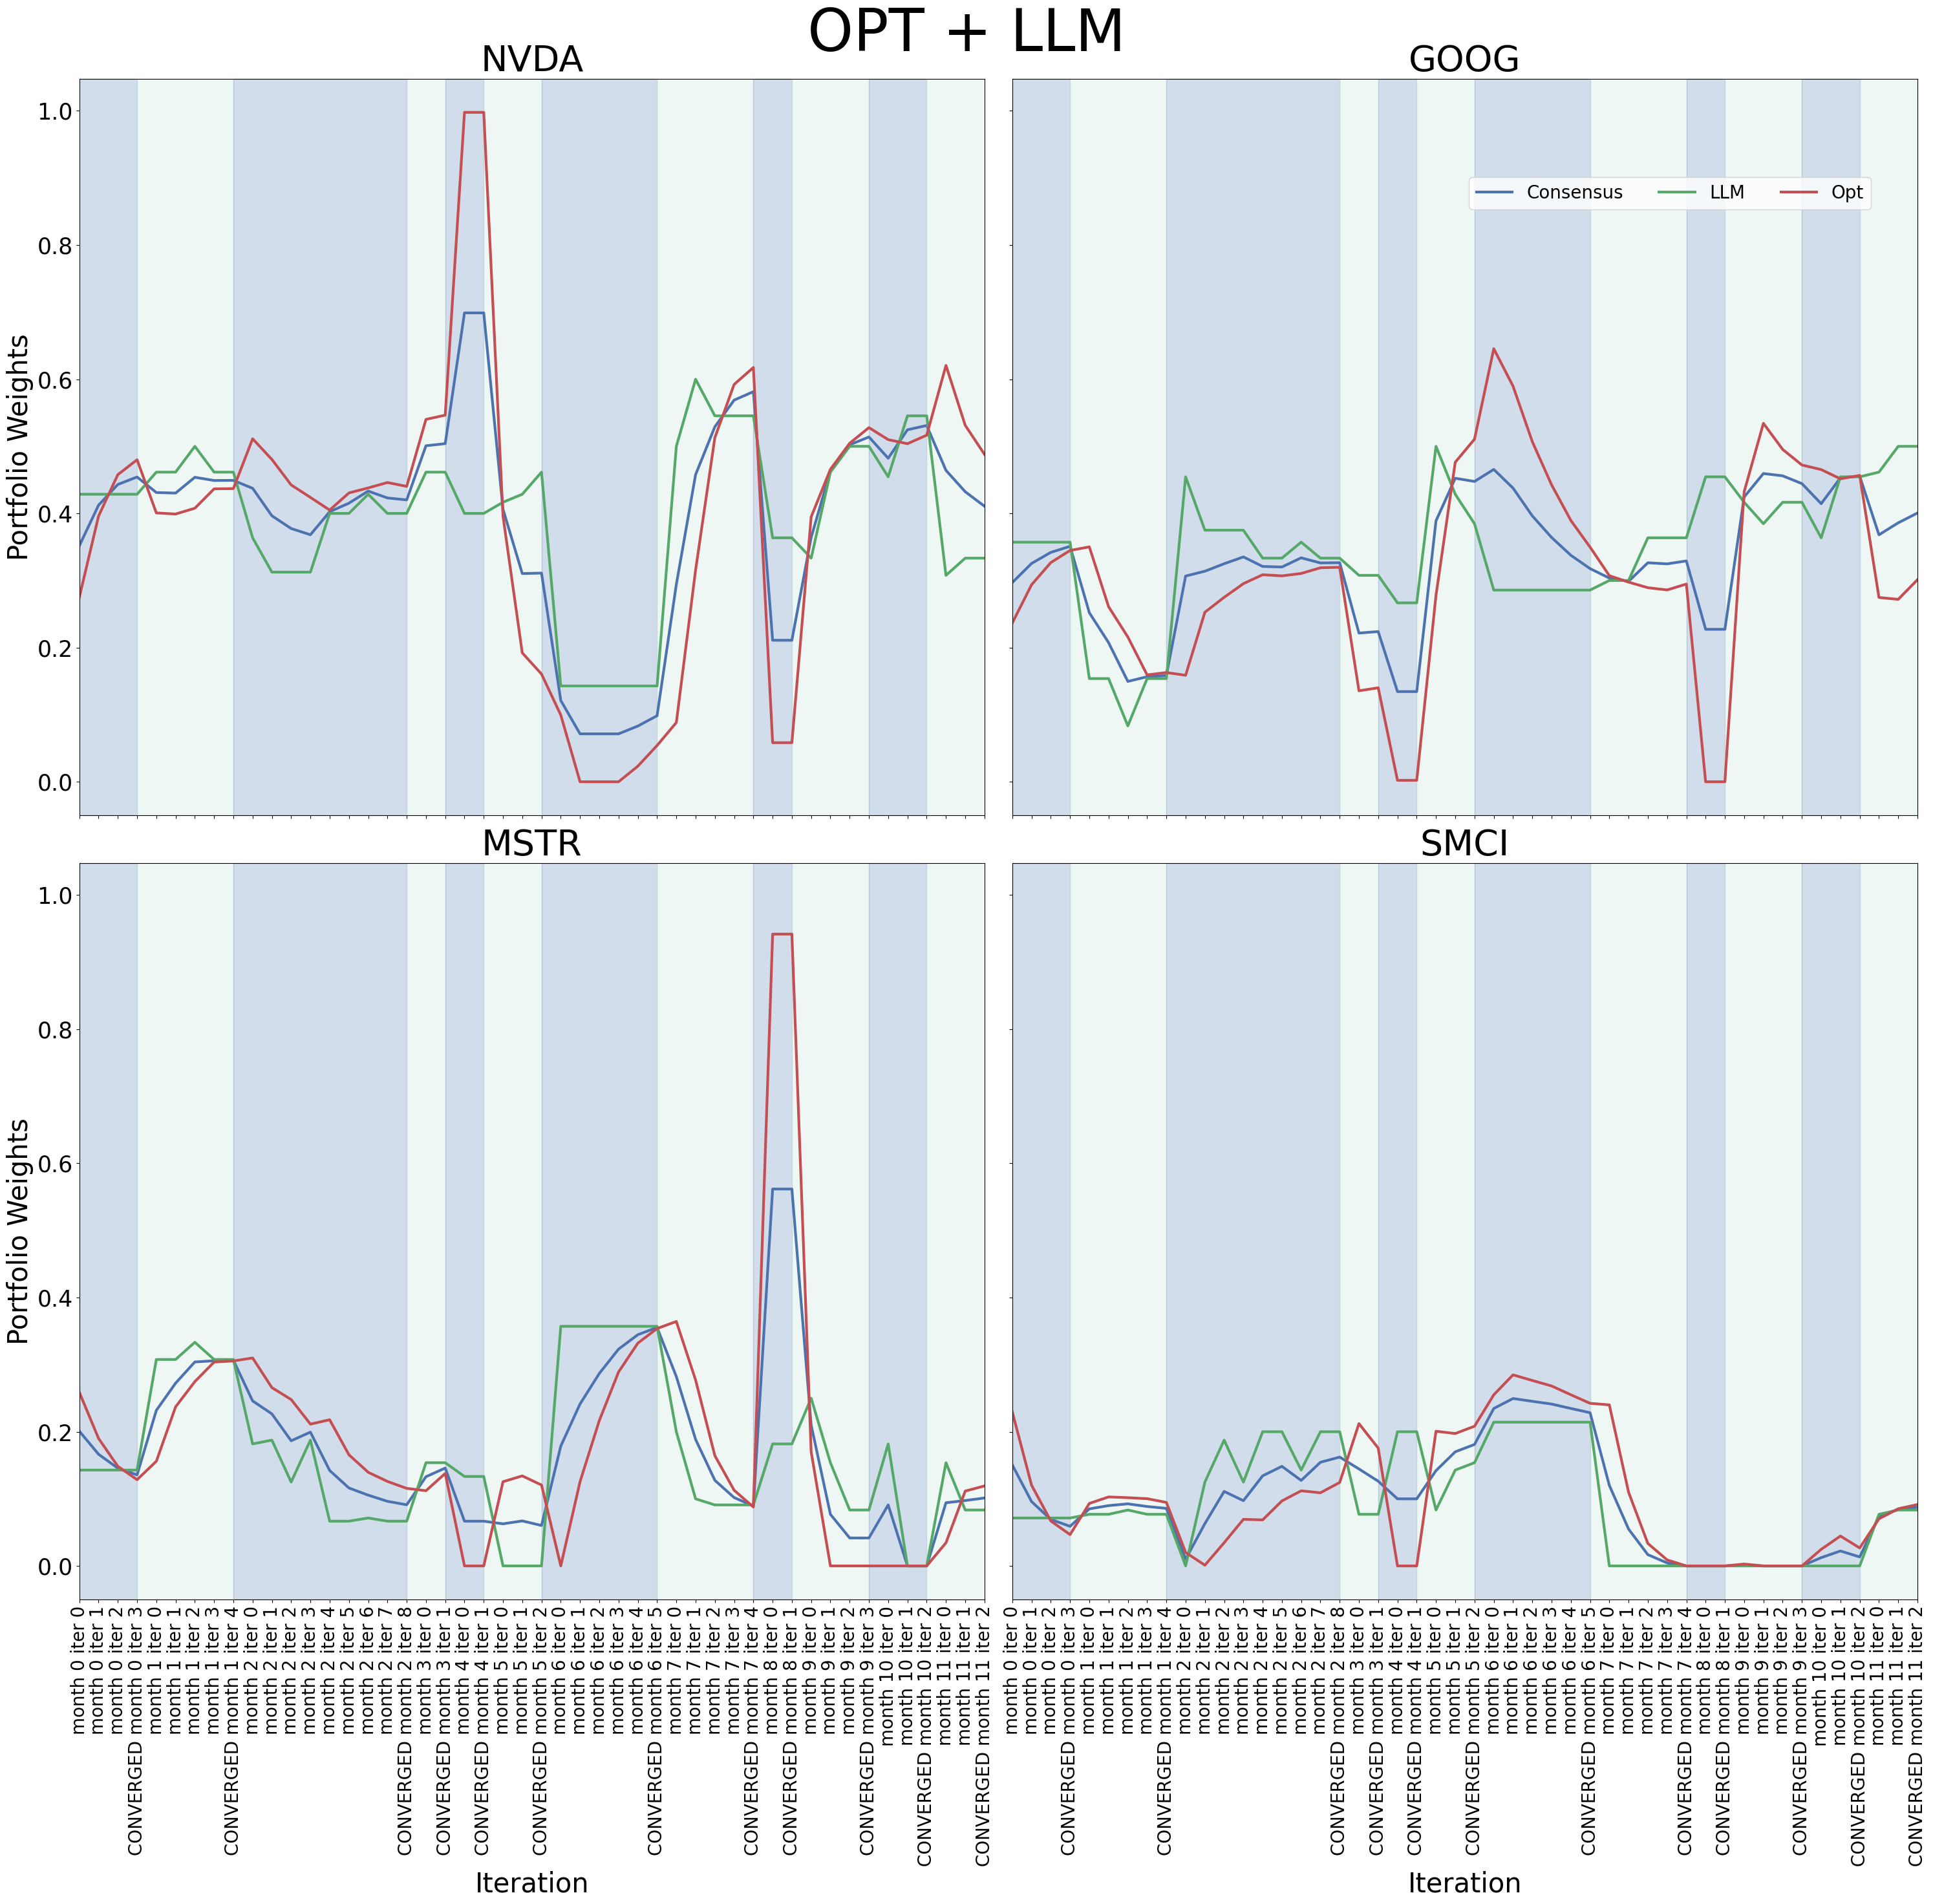

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15*2, 15*2), sharey=True)  # 2x2 grid

fig.suptitle("OPT + LLM", fontsize=65)

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255,2), round(143/255,2), round(191/255,2), 0.3)
green_region = (round(201/255,2), round(230/255,2), round(219/255,2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

for i, ticker in enumerate(tickers):

    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if i == 0:
        axes[i].plot(df['status'], df[f'all {ticker}'], label='Consensus', linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM', linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt', linewidth=3)
    else:
        axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=3)

    axes[i].set_title(f'{ticker}', fontsize=40)
    axes[i].tick_params(axis='x', rotation=90, labelsize=20)
    axes[i].tick_params(axis='y', labelsize=25)

    axes[i].set_xlim(0, len(df['status']) - 1)

    if i == 0 or i == 2: 
        axes[i].set_ylabel("Portfolio Weights", fontsize=30)
    if i == 0 or i == 1:
        axes[i].tick_params(axis='x', labelbottom=False)
    if i == 2 or i == 3:
        axes[i].set_xlabel("Iteration", fontsize=30)

# Add common legend and adjust layout
fig.legend(loc=(0.76, 0.89), ncol=4, fontsize=20)
plt.tight_layout()

plt.savefig('assets/output.png', dpi=300, bbox_inches='tight')

#### Backtesting
Seeing how the strategies perform based on historical data

In [20]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)
all_weights = ["all NVDA", "all GOOG", "all MSTR", "all SMCI"]

# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)


24442.86695594847
21952.59439571716
29033.21512484957


#### Plot the backtesting

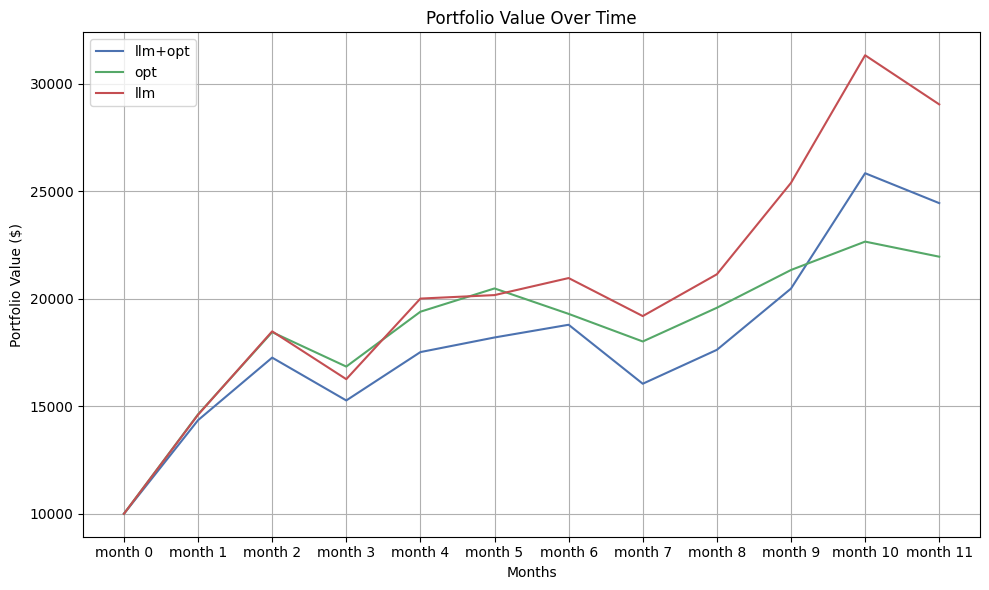

In [21]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart (marker='o' to show points)
plt.plot(months, portfolio_history_coordinated, linestyle='-', label='llm+opt')
plt.plot(months, portfolio_history_opt, linestyle='-', label='opt')
plt.plot(months, portfolio_history_llm, linestyle='-', label='llm')

# Optional: If you prefer a bar chart instead of a line chart, use:
# plt.bar(months, portfolio_value_history, color='blue')

plt.title("Portfolio Value Over Time")
plt.xlabel("Months")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

plt.legend()

plt.tight_layout()

plt.show()